# 💫Deep Dream Visualization
---

**DeepDream** is a technique for **generating visual art using deep neural networks**. The process involves feeding an image into a **pre-trained deep neural network** and then using gradient ascent to maximize the activations of certain neurons in the network. This creates a new image that exaggerates the patterns and features detected by the selected neurons. The process can be repeated recursively, with the output image serving as input to the same network and activating different neurons, resulting in even more complex and abstract images.

DeepDream has been used to generate stunning and surreal images that seem to reveal the hidden workings of the neural network. Beyond its artistic value, DeepDream can also be **used to better understand how neural networks work** and what features they are detecting in different types of data, such as images or sounds.

In this notebook, I will show how DeepDream works with **visualization examples** to help readers understand the process and its potential applications.

# Imports

In [1]:
import os
from io import BytesIO

import numpy as np
import scipy.ndimage as nd
import PIL
import PIL.Image
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, clear_output, Image, display

import torch
from torch.autograd import Variable
from torch.optim import SGD
from torchvision import models, transforms

# Utility functions

In [2]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def showtensor(a):
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    showarray(inp)
    clear_output(wait=True)

def plot_images(im, titles=None):
    plt.figure(figsize=(30, 20))
    
    for i in range(len(im)):
        plt.subplot(10 / 5 + 1, 5, i + 1)
        plt.axis('off')
        if titles is not None:
            plt.title(titles[i])
        plt.imshow(im[i])
        
    plt.pause(0.001)
    
normalise = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

normalise_resize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def init_image(size=(400, 400, 3)):
    img = PIL.Image.fromarray(np.uint8(np.full(size, 150)))
    img = PIL.Image.fromarray(np.uint8(np.random.uniform(150, 180, size)))
    img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def load_image(path, resize=False, size=None):
    img = PIL.Image.open(path)
    
    if size is not None:
        img.thumbnail(size, PIL.Image.Resampling.LANCZOS)
        
    if resize:
        img_tensor = normalise_resize(img).unsqueeze(0)
    else:
        img_tensor = normalise(img).unsqueeze(0)
    img_np = img_tensor.numpy()
    return img, img_tensor, img_np

def tensor_to_img(t):
    a = t.numpy()
    mean = np.array([0.485, 0.456, 0.406]).reshape([1, 1, 3])
    std = np.array([0.229, 0.224, 0.225]).reshape([1, 1, 3])
    inp = a[0, :, :, :]
    inp = inp.transpose(1, 2, 0)
    inp = std * inp + mean
    inp *= 255
    inp = np.uint8(np.clip(inp, 0, 255))
    return PIL.Image.fromarray(inp)

def image_to_variable(image, requires_grad=False, cuda=False):
    if cuda:
        image = Variable(image.cuda(), requires_grad=requires_grad)
    else:
        image = Variable(image, requires_grad=requires_grad)
    return image

With the helper function, we can easily load the sample images in different format as Image, tensor or numpy array.

Let's display what we will use for the Deep Dream model.

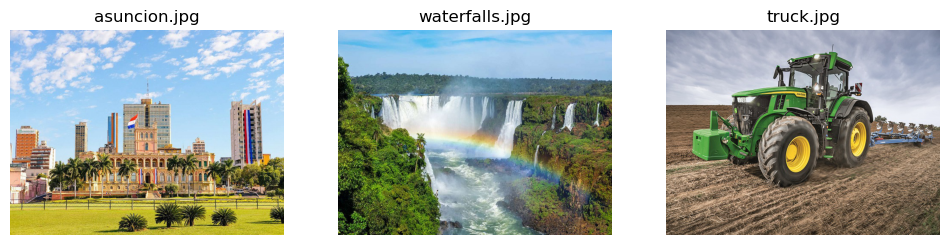

In [3]:
files = [
    '/kaggle/input/random-sample-images/asuncion.jpg',
    '/kaggle/input/random-sample-images/waterfalls.jpg',
    '/kaggle/input/random-sample-images/truck.jpg'
]
plt.figure(figsize=(12, 3))
for i, file in enumerate(files):
    img, img_tensor, img_np = load_image(file)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(file.split('/')[-1])
    plt.axis('off')

# Model
Here, we will load a **VGG-16 pre-trained model**, which has already been trained on a vast dataset of images and has learned to detect various patterns and features. Specifically, we will generate with it captivating DeepDream images that showcase the unique and abstract patterns learned by the network.

In [4]:
# Load the model architecture and pretrained weights
model = models.vgg16()
model.load_state_dict(torch.load("../input/vgg16/vgg16.pth"))

for param in model.parameters():
    param.requires_grad = False

# Use CUDA
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
if use_gpu:
    print("Using CUDA")
    model.cuda()

Using CUDA


# Octaver function
The **Octaver function** is an important component of the DeepDream algorithm that helps to produce more detailed and complex DeepDream images. The basic idea behind it is to apply the DeepDream algorithm at different scales or octaves of the original input image, so that both fine and coarse patterns are captured in the output.

The function starts by **scaling the input image down to a smaller size, and then applies the DeepDream algorithm** on this smaller image to generate a new image that exaggerates certain patterns in the network. The process is **repeated for each octave**, gradually increasing the size of the image until the original input size is reached. This multi-scale approach allows the network to capture patterns at different levels of detail, producing more intricate and visually appealing DeepDream images.

Additionally, the Octaver function also helps to mitigate the issue of loss of image details that can occur during the DeepDream algorithm by **blending the output images at different scales** together to produce a final output image that preserves both fine and coarse details.

Below is a flowchart of this function:

<a href="https://zupimages.net/viewer.php?id=23/12/xxmx.png"><img src="https://zupimages.net/up/23/12/xxmx.png" alt="" /></a>


In [5]:
def octaver_fn(model, base_img, step_fn, octave_n=6, octave_scale=1.4, iter_n=10, **step_args):
    octaves = [base_img]
    
    for i in range(octave_n - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1.0 / octave_scale, 1.0 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(octaves[::-1]):
        h, w = octave_base.shape[-2:]
        
        if octave > 0:
            h1, w1 = detail.shape[-2:]
            detail = nd.zoom(detail, (1, 1, 1.0 * h / h1, 1.0 * w / w1), order=1)
        
        src = octave_base + detail
        
        for i in range(iter_n):
            src = step_fn(model, src, **step_args)

        detail = src.numpy() - octave_base

    return src

# Deep Dream

In [6]:
def objective(dst, guide_features):
    if guide_features is None:
        return dst.data
    else:
        x = dst.data[0].cpu().numpy()
        y = guide_features.data[0].cpu().numpy()
        ch, w, h = x.shape
        x = x.reshape(ch, -1)
        y = y.reshape(ch, -1)
        A = x.T.dot(y)
        diff = y[:, A.argmax(1)]
        diff = torch.Tensor(np.array([diff.reshape(ch, w, h)])).cuda()
        return diff

def make_step(model, img, objective=objective, control=None, step_size=1.5, end=28, jitter=32):
    global use_gpu
    
    mean = np.array([0.485, 0.456, 0.406]).reshape([3, 1, 1])
    std = np.array([0.229, 0.224, 0.225]).reshape([3, 1, 1])
    
    ox, oy = np.random.randint(-jitter, jitter+1, 2)
    
    img = np.roll(np.roll(img, ox, -1), oy, -2)
    tensor = torch.Tensor(img) 
    
    img_var = image_to_variable(tensor, requires_grad=True, cuda=use_gpu)
    model.zero_grad()
      
    x = img_var
    for index, layer in enumerate(model.features.children()):
        x = layer(x)
        if index == end:
            break
    
    delta = objective(x, control)
    x.backward(delta)
    
    #L2 Regularization on gradients
    mean_square = torch.Tensor([torch.mean(img_var.grad.data ** 2)])
    if use_gpu:
        mean_square = mean_square.cuda()
    img_var.grad.data /= torch.sqrt(mean_square)
    img_var.data.add_(img_var.grad.data * step_size)
    
    result = img_var.data.cpu().numpy()
    result = np.roll(np.roll(result, -ox, -1), -oy, -2)
    result[0, :, :, :] = np.clip(result[0, :, :, :], -mean / std, (1 - mean) / std)
    showtensor(result)
    
    return torch.Tensor(result)
                                                             
def deepdream(model, base_img, octave_n=6, octave_scale=1.4, 
              iter_n=10, end=28, control=None, objective=objective, 
              step_size=1.5, jitter=32):
    
    return octaver_fn(
              model, base_img, step_fn=make_step, 
              octave_n=octave_n, octave_scale=octave_scale, 
              iter_n=iter_n, end=end, control=control,
              objective=objective, step_size=step_size, jitter=jitter
           )

# Display

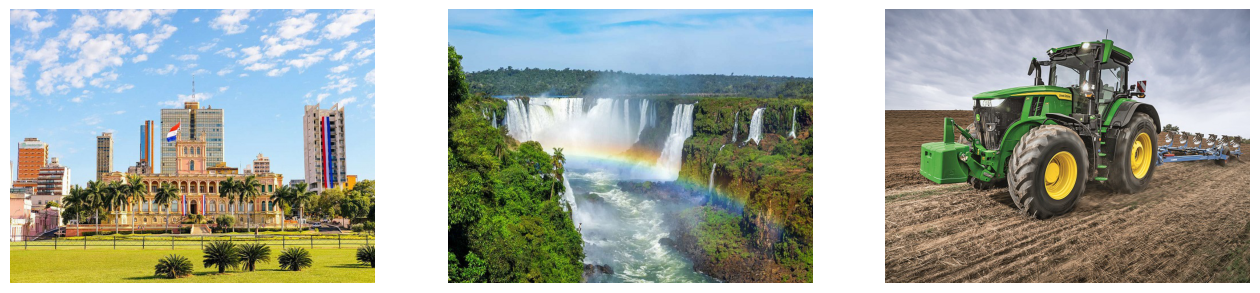

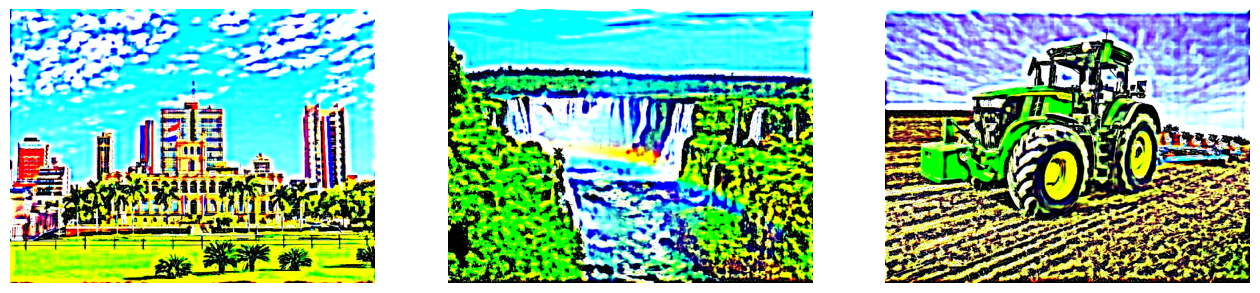

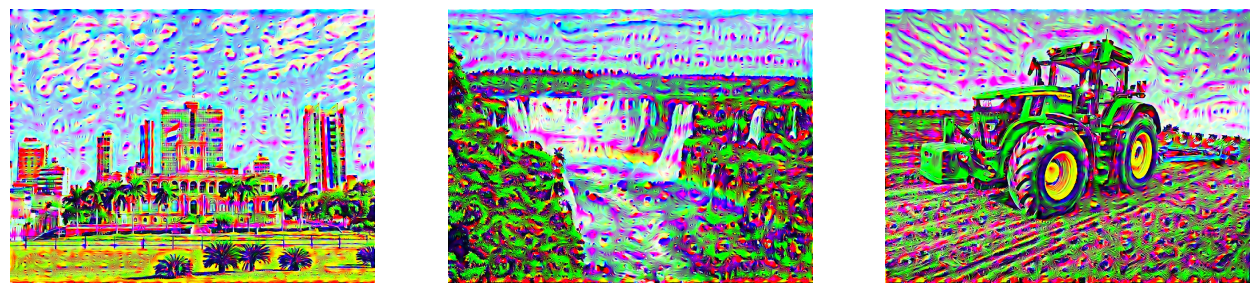

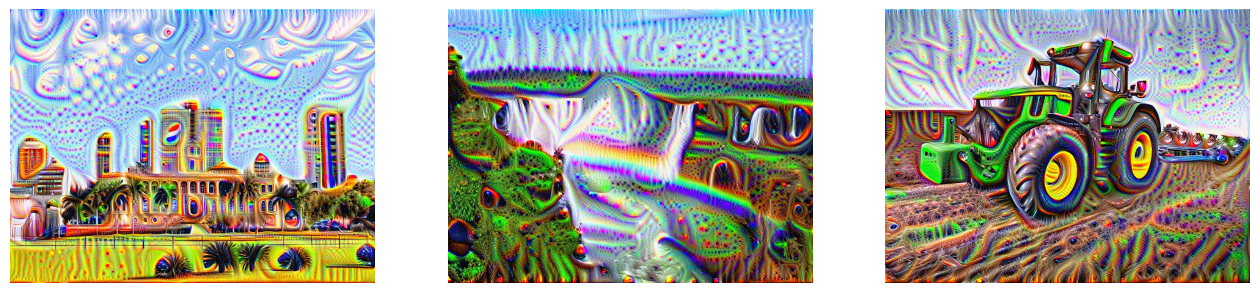

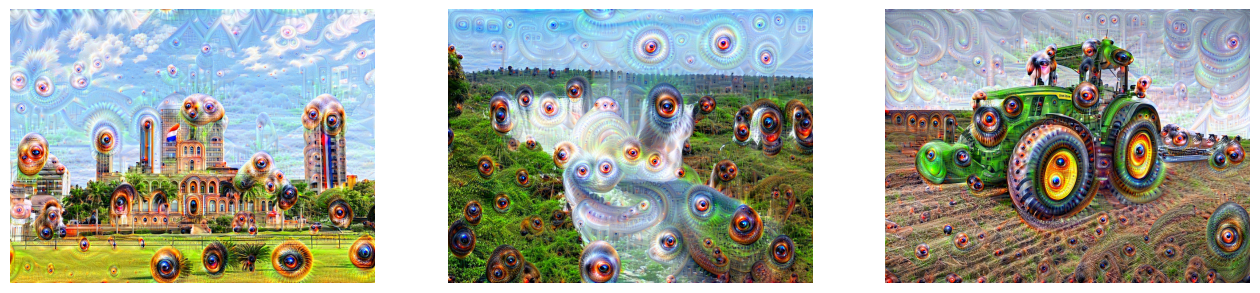

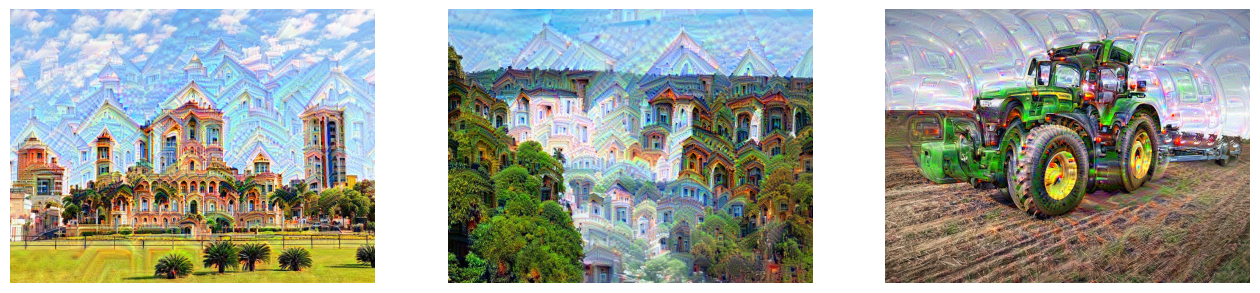

In [7]:
plt.figure(figsize=(16, 4))
for i, file in enumerate(files):
    img, img_tensor, img_np = load_image(file)
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.axis('off')

ends = [0, 6, 14, 20, 28]
for end in ends:
    plt.figure(figsize=(16, 4))
    for i, file in enumerate(files):
        img, img_tensor, img_np = load_image(file)
        dream = deepdream(model, img_np, end=end, step_size=0.06, octave_n=6)
        dream = tensor_to_img(dream)
        plt.subplot(1, 3, i+1)
        plt.imshow(dream)
        plt.axis('off')

# Sources
- [Deep Dreams (with Caffe)](https://github.com/google/deepdream/blob/master/dream.ipynb)
- [TensorFlow - Tutorials](https://github.com/Hvass-Labs/TensorFlow-Tutorials)
- [Convolutional Network Visualizations & Deep Dream](https://www.kaggle.com/code/carloalbertobarbano/convolutional-network-visualizations-deep-dream/notebook)